<h1 style="color:red; font-family: 'Helvetica Neue', sans-serif; font-size:40px; text-align: center; font-weight:bold; font-style:italic">Skin Disease: Image Classification</h1>

<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Installing Modules</h1>

In [ ]:
!pip install keras -tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)


In [ ]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Importing Libraries</h1>

In [ ]:
#basics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#utility & processing
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#cnn architecture
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#keras tuner
import keras_tuner
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

#transfer learning
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.xception import Xception

#warnings
import warnings
warnings.filterwarnings('ignore')


print('we are currently using tensorflow version', tf.__version__)

we are currently using tensorflow version 2.12.0


<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Setting up an environment</h1>

In [ ]:
input_shape_2D=(224,224)
input_shape_3D= (224,224,3)
seed=1
batch_size=32
epochs=30
stopper=EarlyStopping(patience=5)

<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Uploading image dataset</h1>



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#loading image data
data_ds= tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/TA/Data/Augmentasi_Data/800data',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=None,
    image_size=input_shape_2D,
    seed=seed
)

Found 2165 files belonging to 3 classes.


In [ ]:
#class labels
class_names = data_ds.class_names

print("Class Names:", class_names)

Class Names: ['eksim', 'psoriasis', 'scabies']


In [ ]:
def show_images(images, labels):
    fig, axes = plt.subplots(8, 4, figsize=(10, 10))
    axes = axes.flatten()
    for i, (img, label) in enumerate(zip(images, labels)):
        axes[i].imshow(img.numpy().astype("uint8"))
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

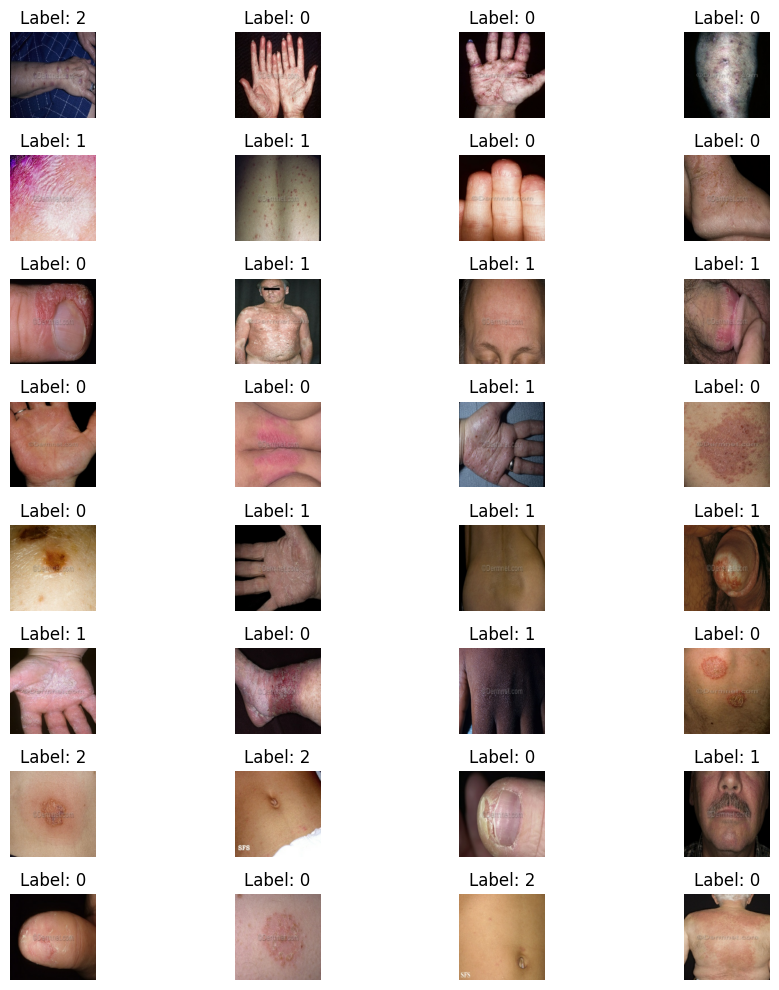

In [ ]:
#displaying image batch of 32
batched_ds = data_ds.batch(batch_size)

batch = next(iter(batched_ds))
images, labels = batch

images, labels = next(iter(batched_ds))
show_images(images, labels)

<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Data Processing</h1>

In [ ]:
X=[]
y= []

for image, label in data_ds.batch(119):
  for img, lab in zip(image, label):
    X.append(img)
    y.append(lab.numpy())

In [ ]:
# converting to numpy array
X= np.array(X)
y= np.array(y)

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

# Split Data

In [ ]:
X_train = X_train/255
X_test = X_test/255

In [ ]:
print("shape of X_train_scaled:", X_train.shape)
print("shape of y_train:", y_train.shape)
print("shape of X_test_scaled:", X_test.shape)
print("shape of y_test:", y_test.shape)

shape of X_train_scaled: (1623, 224, 224, 3)
shape of y_train: (1623,)
shape of X_test_scaled: (542, 224, 224, 3)
shape of y_test: (542,)


# Encoding

In [ ]:
y_train = to_categorical(y_train, num_classes=len(class_names))
y_test = to_categorical(y_test, num_classes=len(class_names))

<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">CNN Architecture</h1>

In [ ]:
own_model=Sequential()

# adding first convloutional layer
own_model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape_3D))
own_model.add(MaxPooling2D())

# adding second convloutional layer
own_model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
own_model.add(MaxPooling2D())

# adding third convloutional layer
own_model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
own_model.add(MaxPooling2D())

# adding flatten layer
own_model.add(Flatten())

# adding fully connected layers
own_model.add(Dense(200, activation='relu'))

#adding output layer : number of classes are 3
own_model.add(Dense(3, activation='softmax'))

In [ ]:
# looking at the architecture summary
own_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [ ]:
# compiling model
own_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit the model
history=own_model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=epochs)

Epoch 1/30
51/51 [==============================] - 15s 58ms/step - loss: 1.5614 - accuracy: 0.4104 - val_loss: 1.0271 - val_accuracy: 0.4705
Epoch 2/30
51/51 [==============================] - 2s 42ms/step - loss: 0.9789 - accuracy: 0.4929 - val_loss: 1.0134 - val_accuracy: 0.4742
Epoch 3/30
51/51 [==============================] - 2s 42ms/step - loss: 0.8942 - accuracy: 0.5693 - val_loss: 1.0462 - val_accuracy: 0.4834
Epoch 4/30
51/51 [==============================] - 2s 38ms/step - loss: 0.7786 - accuracy: 0.6278 - val_loss: 1.0770 - val_accuracy: 0.5074
Epoch 5/30
51/51 [==============================] - 2s 36ms/step - loss: 0.6434 - accuracy: 0.7061 - val_loss: 1.2038 - val_accuracy: 0.5092
Epoch 6/30
51/51 [==============================] - 2s 37ms/step - loss: 0.5166 - accuracy: 0.7813 - val_loss: 1.5503 - val_accuracy: 0.5000
Epoch 7/30
51/51 [==============================] - 2s 37ms/step - loss: 0.4160 - accuracy: 0.8201 - val_loss: 1.8006 - val_accuracy: 0.4963
Epoch 8/30
5

In [ ]:
def plot_performance(model_name, acc, val_acc, loss, val_loss):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('{} : Loss'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.subplot(1,2,2)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('{} : Accuracy'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.tight_layout()

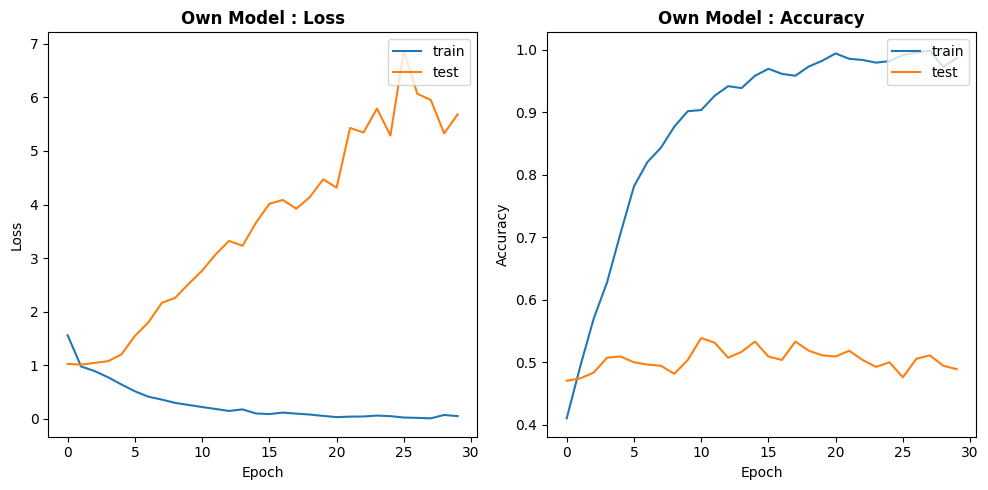

In [ ]:
plot_performance(model_name= 'Own Model',
                 acc=history.history['accuracy'],
                 val_acc=history.history['val_accuracy'],
                 loss=history.history['loss'],
                 val_loss=history.history['val_loss'])

<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Data Augmentation</h1>

In [ ]:
#creating image generator object
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True)

In [ ]:
# training the model
aug_history= own_model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train)//batch_size,
    epochs=epochs
)

Epoch 1/30
50/50 [==============================] - 20s 380ms/step - loss: 1.4780 - accuracy: 0.3853 - val_loss: 1.0944 - val_accuracy: 0.3432
Epoch 2/30
50/50 [==============================] - 18s 360ms/step - loss: 1.0875 - accuracy: 0.4085 - val_loss: 1.0781 - val_accuracy: 0.3856
Epoch 3/30
50/50 [==============================] - 20s 399ms/step - loss: 1.0610 - accuracy: 0.4079 - val_loss: 1.0581 - val_accuracy: 0.4170
Epoch 4/30
50/50 [==============================] - 18s 356ms/step - loss: 1.0458 - accuracy: 0.4255 - val_loss: 1.0498 - val_accuracy: 0.4483
Epoch 5/30
50/50 [==============================] - 18s 354ms/step - loss: 1.0359 - accuracy: 0.4305 - val_loss: 1.0527 - val_accuracy: 0.4557
Epoch 6/30
50/50 [==============================] - 20s 387ms/step - loss: 1.0304 - accuracy: 0.4406 - val_loss: 1.0291 - val_accuracy: 0.4483
Epoch 7/30
50/50 [==============================] - 18s 363ms/step - loss: 1.0243 - accuracy: 0.4563 - val_loss: 1.0158 - val_accuracy: 0.4576

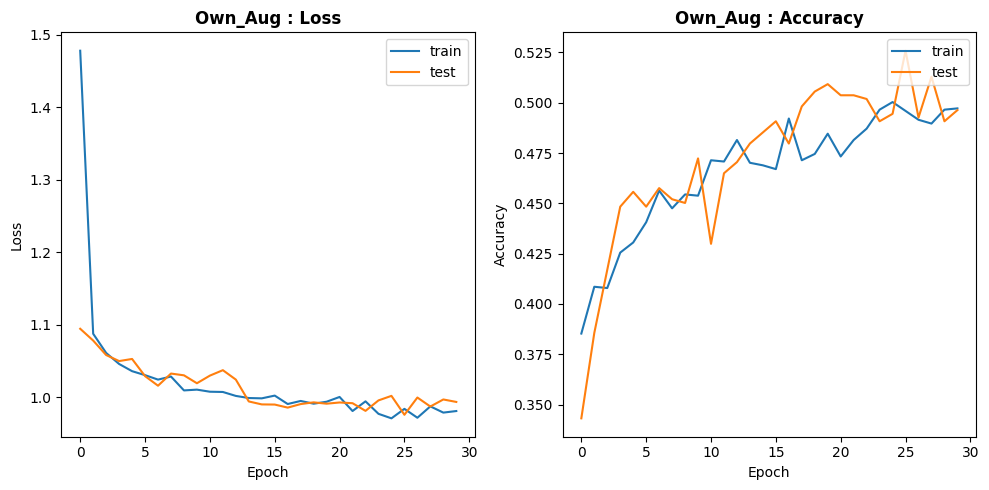

In [ ]:
#visualising model performance
plot_performance(model_name='Own_Aug',
                  acc=aug_history.history['accuracy'],
                 val_acc=aug_history.history['val_accuracy'],
                 loss=aug_history.history['loss'],
                 val_loss=aug_history.history['val_loss'])

- <font color='darkviolet'>The accuracy of the model increased significantly in the second epoch, which could be attributed to the additional training examples provided by the augmentation process.</font>
- <font color='darkviolet'>The validation accuracy of the model fluctuated a lot and didn't show a significant improvement over the baseline model.</font>
- <font color='darkviolet'>The model shows some overfitting as the training accuracy keeps increasing while the validation accuracy remains stagnant.</font>
- <font color='darkviolet'>The augmented data seems to have helped the model generalize better as the validation accuracy didn't drop as much as the baseline model.</font>
- <font color='darkviolet'>The training time increased due to the additional computation required to augment the data during training.</font>

<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Keras Tuner</h1>

In [ ]:
def build_model(hp):
  new_model=Sequential()

  # adding first convloutional layer
  new_model.add(Conv2D(
      filters= hp.Int('conv_1_filter', min_value=8, max_value=32, step=8),
      kernel_size=hp.Choice('conv_1_kernel', values= [2,3]),
      padding=hp.Choice('conv_1_pad', values=['same', 'valid']),
      activation='relu', input_shape=input_shape_3D))
  new_model.add(MaxPooling2D())

  # adding second convloutional layer
  new_model.add(Conv2D(
      filters= hp.Int('conv_2_filter', min_value=16, max_value=64, step=16),
      kernel_size=hp.Choice('conv_2_kernel', values= [2,3]),
      padding=hp.Choice('conv_2_pad', values=['same', 'valid']),
      activation='relu'))
  new_model.add(MaxPooling2D())

  # adding third convloutional layer
  new_model.add(Conv2D(
      filters= hp.Int('conv_3_filter', min_value=32, max_value=64, step=16),
      kernel_size=hp.Choice('conv_3_kernel', values= [2,3]),
      padding=hp.Choice('conv_3_pad', values=['same', 'valid']),
      activation='relu'))
  new_model.add(MaxPooling2D())

  # adding flatten layer
  new_model.add(Flatten())

  # adding fully connected layers
  new_model.add(Dense(
      units=hp.Int('dense_1_units', min_value=50, max_value=250, step=50),
      activation='relu'
      ))

  #adding output layer : number of classes are 3
  new_model.add(Dense(3, activation='softmax'))

  new_model.compile(
      optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])),
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

  return new_model

In [ ]:
tuner_search=RandomSearch(build_model, objective='val_accuracy', max_trials=3, directory='output', project_name='SkinDisease')

In [ ]:
tuner_search.search(
    datagen.flow(X_train, y_train),
    validation_data=(X_test, y_test),
    epochs=10
)

Trial 3 Complete [00h 03m 15s]
val_accuracy: 0.49261993169784546

Best val_accuracy So Far: 0.49261993169784546
Total elapsed time: 00h 09m 51s


In [ ]:
tuned_model=tuner_search.get_best_models(num_models=1)[0]

In [ ]:
tuned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 48)      6960      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 48)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 54, 54, 48)        20784     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 27, 27, 48)       0

In [ ]:
# Training the model
tuned_history= tuned_model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train)//batch_size,
    initial_epoch=10,
    epochs=epochs
)

Epoch 11/30
50/50 [==============================] - 21s 402ms/step - loss: 1.0049 - accuracy: 0.4632 - val_loss: 1.0007 - val_accuracy: 0.4742
Epoch 12/30
50/50 [==============================] - 18s 358ms/step - loss: 1.0011 - accuracy: 0.4645 - val_loss: 1.0131 - val_accuracy: 0.4834
Epoch 13/30
50/50 [==============================] - 18s 357ms/step - loss: 0.9978 - accuracy: 0.4856 - val_loss: 0.9879 - val_accuracy: 0.5037
Epoch 14/30
50/50 [==============================] - 20s 399ms/step - loss: 0.9899 - accuracy: 0.4890 - val_loss: 0.9933 - val_accuracy: 0.5074
Epoch 15/30
50/50 [==============================] - 18s 357ms/step - loss: 0.9903 - accuracy: 0.4984 - val_loss: 0.9958 - val_accuracy: 0.4779
Epoch 16/30
50/50 [==============================] - 18s 361ms/step - loss: 0.9846 - accuracy: 0.5009 - val_loss: 1.0082 - val_accuracy: 0.4963
Epoch 17/30
50/50 [==============================] - 20s 401ms/step - loss: 0.9714 - accuracy: 0.4997 - val_loss: 0.9790 - val_accuracy:

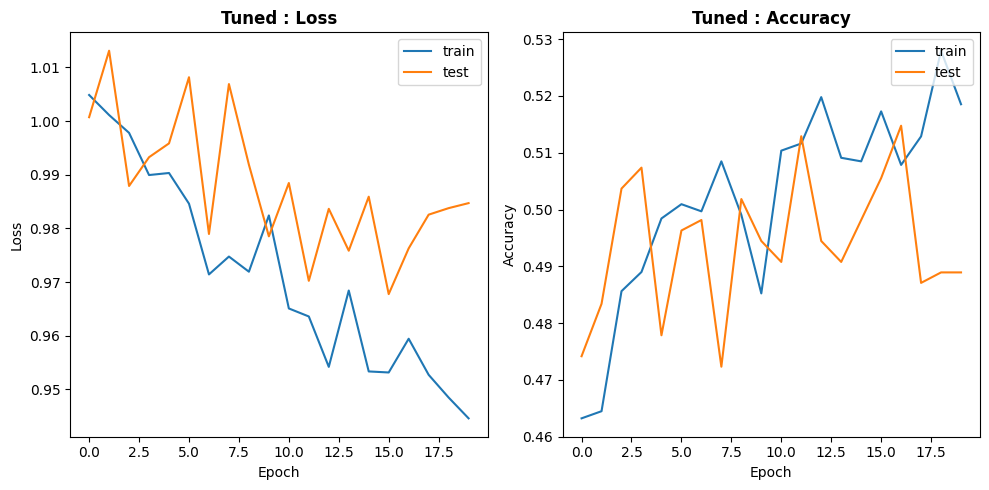

In [ ]:
plot_performance(model_name='Tuned',
                  acc=tuned_history.history['accuracy'],
                 val_acc=tuned_history.history['val_accuracy'],
                 loss=tuned_history.history['loss'],
                 val_loss=tuned_history.history['val_loss'])

<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Arsitektur CNN</h1>

## InceptionV3

In [ ]:
inception_base=tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape_3D,
)

#unfreezing the convloution layers
inception_base.trainable=True
set_trainable=False

for layer in inception_base.layers:
  if layer.name=='mixed9_0':
    set_trainable=True

  if set_trainable==True:
    layer.trainable=True

  else:
    layer.trainable=False


# building fully connected layers
inception_model= Sequential()

inception_model.add(inception_base)
inception_model.add(Flatten())

inception_model.add(Dense(128, activation='relu'))
inception_model.add(Dense(3, activation='softmax'))


#compiling
inception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 5s 0us/step


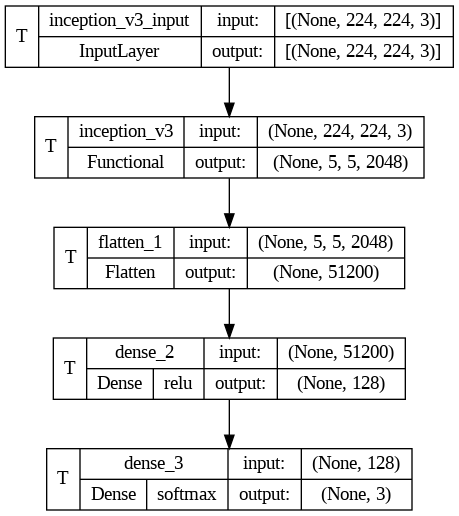

In [ ]:
tf.keras.utils.plot_model(
    inception_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True,
)

#### Without Augmentation

In [ ]:
#training model
checkpointer_inception = ModelCheckpoint(filepath='inception.weights.best.hdf5', verbose=3, save_best_only=True)

inception_history= inception_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    callbacks=[checkpointer_inception]
)

Epoch 1/30
51/51 [==============================] - ETA: 0s - loss: 3.4644 - accuracy: 0.5157
Epoch 1: val_loss improved from inf to 1.92494, saving model to inception.weights.best.hdf5
51/51 [==============================] - 27s 307ms/step - loss: 3.4644 - accuracy: 0.5157 - val_loss: 1.9249 - val_accuracy: 0.5000
Epoch 2/30
51/51 [==============================] - ETA: 0s - loss: 0.3789 - accuracy: 0.8552
Epoch 2: val_loss improved from 1.92494 to 1.15412, saving model to inception.weights.best.hdf5
51/51 [==============================] - 11s 217ms/step - loss: 0.3789 - accuracy: 0.8552 - val_loss: 1.1541 - val_accuracy: 0.6513
Epoch 3/30
51/51 [==============================] - ETA: 0s - loss: 0.1119 - accuracy: 0.9606
Epoch 3: val_loss did not improve from 1.15412
51/51 [==============================] - 5s 106ms/step - loss: 0.1119 - accuracy: 0.9606 - val_loss: 1.2472 - val_accuracy: 0.6642
Epoch 4/30
51/51 [==============================] - ETA: 0s - loss: 0.0350 - accuracy: 0

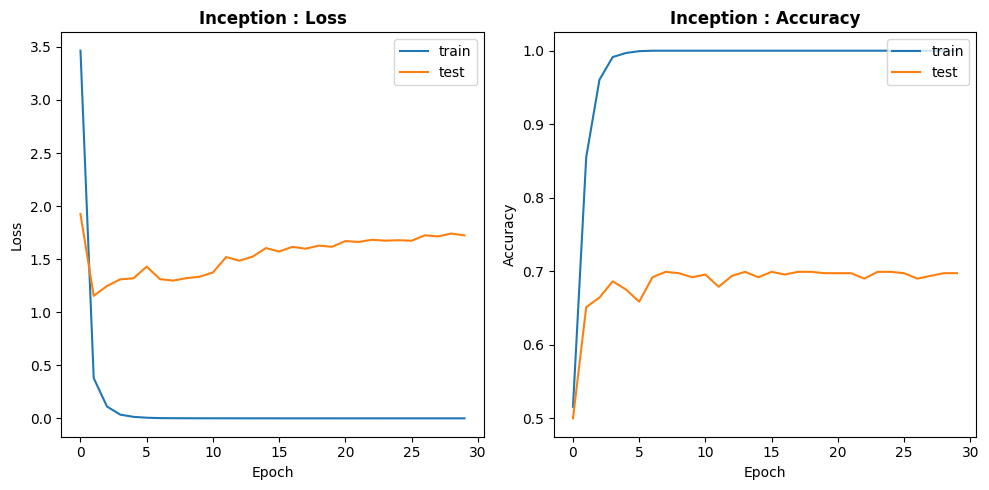

In [ ]:
plot_performance(model_name='Inception',
                acc=inception_history.history['accuracy'],
                 val_acc=inception_history.history['val_accuracy'],
                 loss=inception_history.history['loss'],
                 val_loss=inception_history.history['val_loss'])

#### With Augmentation

In [ ]:
#training model
checkpointer_inception_aug = ModelCheckpoint(filepath='inception_aug.weights.best.hdf5', verbose=3, save_best_only=True)

inception_history_aug= inception_model.fit(
    datagen.flow(X_train,y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train)//batch_size,
    epochs=epochs,
    callbacks=[checkpointer_inception_aug]
)

Epoch 1/30
50/50 [==============================] - ETA: 0s - loss: 1.4211 - accuracy: 0.4268
Epoch 1: val_loss improved from inf to 1.14027, saving model to inception_aug.weights.best.hdf5
50/50 [==============================] - 28s 507ms/step - loss: 1.4211 - accuracy: 0.4268 - val_loss: 1.1403 - val_accuracy: 0.4170
Epoch 2/30
50/50 [==============================] - ETA: 0s - loss: 1.0101 - accuracy: 0.4651
Epoch 2: val_loss improved from 1.14027 to 1.00016, saving model to inception_aug.weights.best.hdf5
50/50 [==============================] - 25s 500ms/step - loss: 1.0101 - accuracy: 0.4651 - val_loss: 1.0002 - val_accuracy: 0.4779
Epoch 3/30
50/50 [==============================] - ETA: 0s - loss: 0.9894 - accuracy: 0.4393
Epoch 3: val_loss did not improve from 1.00016
50/50 [==============================] - 20s 389ms/step - loss: 0.9894 - accuracy: 0.4393 - val_loss: 1.0133 - val_accuracy: 0.4022
Epoch 4/30
50/50 [==============================] - ETA: 0s - loss: 0.9569 - ac

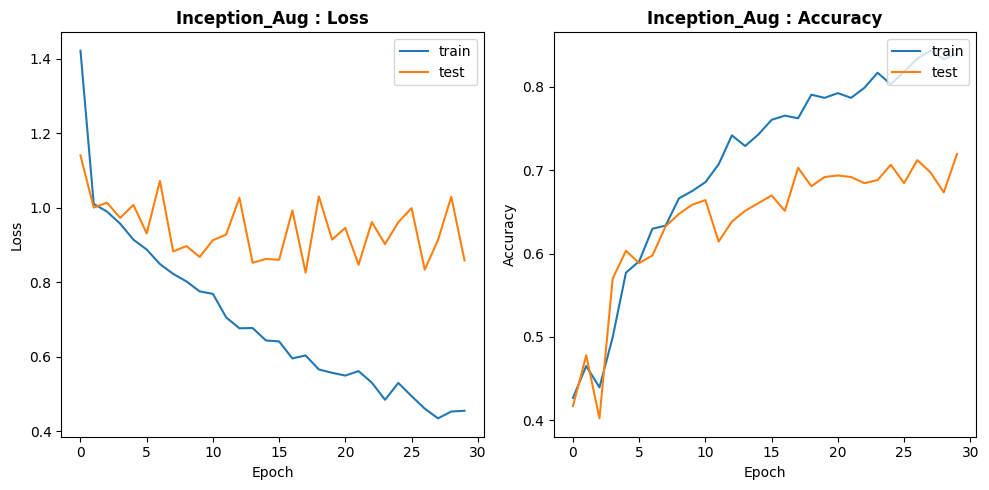

In [ ]:
plot_performance(model_name='Inception_Aug',
                acc=inception_history_aug.history['accuracy'],
                 val_acc=inception_history_aug.history['val_accuracy'],
                 loss=inception_history_aug.history['loss'],
                 val_loss=inception_history_aug.history['val_loss'])

## ResNET

In [ ]:
resnet_base=ResNet152V2(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape_3D
)

resnet_base.trainable=True
set_trainable=False

for layer in resnet_base.layers:
  if layer.name=='conv5_block1_preact_bn':
    set_trainable=True

  if set_trainable==True:
    layer.trainable=True
  else:
    layer.trainable=False

#builing fully connected layers
resnet_model=Sequential()

resnet_model.add(resnet_base)
resnet_model.add(Flatten())

resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(Dense(3, activation='softmax'))

resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

234545216/234545216 [==============================] - 11s 0us/step


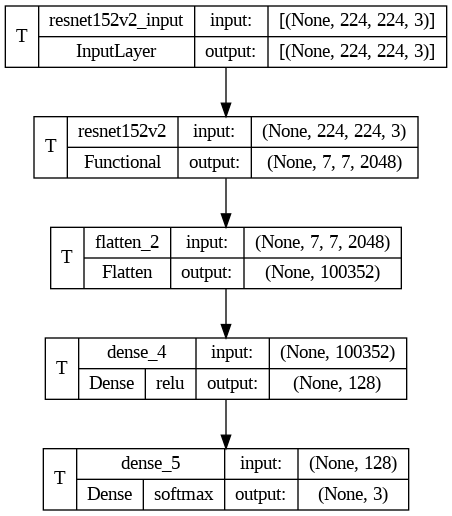

In [ ]:
tf.keras.utils.plot_model(
    resnet_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True,
)

#### Without Augmentation

In [ ]:
resnet_history=resnet_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=epochs
)

Epoch 1/30
51/51 [==============================] - 43s 492ms/step - loss: 2.1968 - accuracy: 0.4325 - val_loss: 1.3157 - val_accuracy: 0.4004
Epoch 2/30
51/51 [==============================] - 19s 379ms/step - loss: 0.9075 - accuracy: 0.5767 - val_loss: 1.9481 - val_accuracy: 0.4815
Epoch 3/30
51/51 [==============================] - 19s 373ms/step - loss: 0.7125 - accuracy: 0.6932 - val_loss: 1.0429 - val_accuracy: 0.6328
Epoch 4/30
51/51 [==============================] - 19s 374ms/step - loss: 0.4953 - accuracy: 0.8090 - val_loss: 3.1790 - val_accuracy: 0.4760
Epoch 5/30
51/51 [==============================] - 18s 352ms/step - loss: 0.4202 - accuracy: 0.8521 - val_loss: 1.6398 - val_accuracy: 0.5904
Epoch 6/30
51/51 [==============================] - 19s 378ms/step - loss: 0.2925 - accuracy: 0.9008 - val_loss: 1.6707 - val_accuracy: 0.6089
Epoch 7/30
51/51 [==============================] - 18s 352ms/step - loss: 0.2386 - accuracy: 0.9267 - val_loss: 2.8650 - val_accuracy: 0.6587

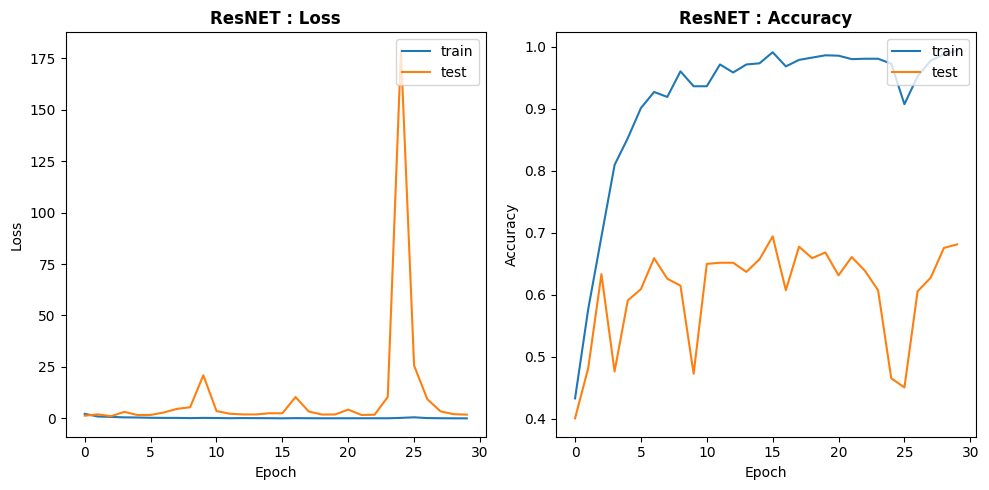

In [ ]:
plot_performance(model_name='ResNET',
                acc=resnet_history.history['accuracy'],
                 val_acc=resnet_history.history['val_accuracy'],
                 loss=resnet_history.history['loss'],
                 val_loss=resnet_history.history['val_loss'])

#### With Augmentation

In [ ]:
resnet_history_aug=resnet_model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train)//batch_size,
    epochs=epochs
)

Epoch 1/30
50/50 [==============================] - 34s 545ms/step - loss: 1.3836 - accuracy: 0.5399 - val_loss: 4.9255 - val_accuracy: 0.4317
Epoch 2/30
50/50 [==============================] - 27s 548ms/step - loss: 0.8887 - accuracy: 0.5971 - val_loss: 2.7831 - val_accuracy: 0.5406
Epoch 3/30
50/50 [==============================] - 29s 576ms/step - loss: 0.9333 - accuracy: 0.5971 - val_loss: 0.9174 - val_accuracy: 0.6070
Epoch 4/30
50/50 [==============================] - 28s 553ms/step - loss: 0.8105 - accuracy: 0.6367 - val_loss: 1.1237 - val_accuracy: 0.6347
Epoch 5/30
50/50 [==============================] - 27s 549ms/step - loss: 0.7552 - accuracy: 0.6581 - val_loss: 0.8076 - val_accuracy: 0.6181
Epoch 6/30
50/50 [==============================] - 27s 536ms/step - loss: 0.7267 - accuracy: 0.6782 - val_loss: 0.7414 - val_accuracy: 0.7085
Epoch 7/30
50/50 [==============================] - 27s 531ms/step - loss: 0.6952 - accuracy: 0.7310 - val_loss: 0.7522 - val_accuracy: 0.6937

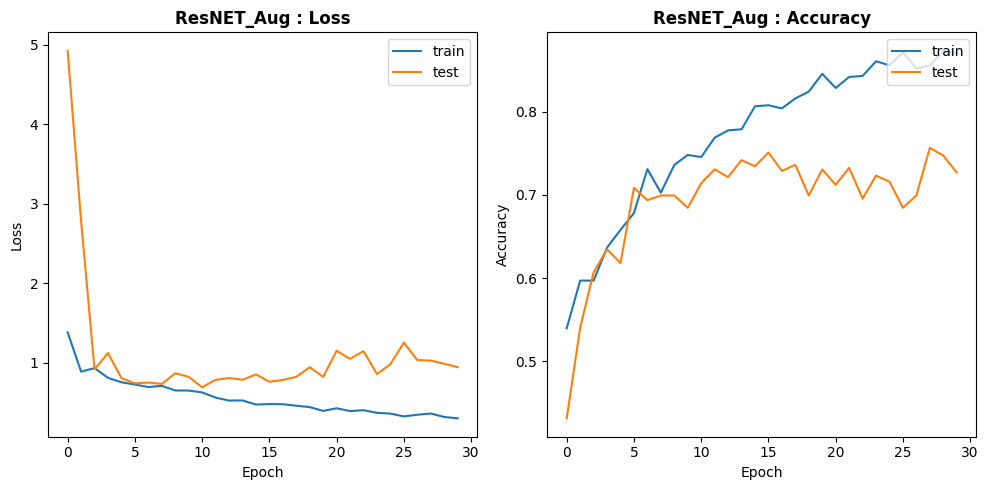

In [ ]:
plot_performance(model_name='ResNET_Aug',
                acc=resnet_history_aug.history['accuracy'],
                 val_acc=resnet_history_aug.history['val_accuracy'],
                 loss=resnet_history_aug.history['loss'],
                 val_loss=resnet_history_aug.history['val_loss'])

## Xception

In [ ]:
xception_base= Xception(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape_3D
)

xception_base.trainable=True
set_trainable=False

for layer in xception_base.layers:
  if layer.name=='add_8':
    set_trainable=True

  if set_trainable==True:
    layer.trainable=True
  else:
    layer.trainable=False

#building fully connected layers
xception_model=Sequential()

xception_model.add(xception_base)
xception_model.add(Flatten())

xception_model.add(Dense(128, activation='relu'))
xception_model.add(Dense(3, activation='softmax'))

xception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

83683744/83683744 [==============================] - 5s 0us/step


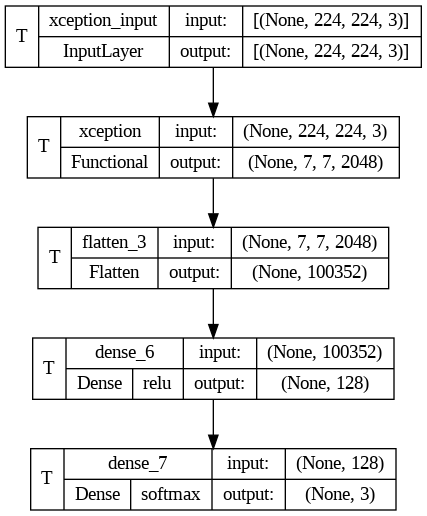

In [ ]:
tf.keras.utils.plot_model(
    xception_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True,
)

#### Without Augmentation

In [ ]:
#training model
checkpointer_xception = ModelCheckpoint(filepath='xception.weights.best.hdf5', verbose=3, save_best_only=True)

xception_history=xception_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    callbacks=[checkpointer_xception]
)

Epoch 1/30
51/51 [==============================] - ETA: 0s - loss: 1.5152 - accuracy: 0.4091
Epoch 1: val_loss improved from inf to 1.02778, saving model to xception.weights.best.hdf5
51/51 [==============================] - 39s 477ms/step - loss: 1.5152 - accuracy: 0.4091 - val_loss: 1.0278 - val_accuracy: 0.3967
Epoch 2/30
51/51 [==============================] - ETA: 0s - loss: 0.9310 - accuracy: 0.5675
Epoch 2: val_loss improved from 1.02778 to 0.91644, saving model to xception.weights.best.hdf5
51/51 [==============================] - 20s 387ms/step - loss: 0.9310 - accuracy: 0.5675 - val_loss: 0.9164 - val_accuracy: 0.5646
Epoch 3/30
51/51 [==============================] - ETA: 0s - loss: 0.6667 - accuracy: 0.7153
Epoch 3: val_loss did not improve from 0.91644
51/51 [==============================] - 14s 268ms/step - loss: 0.6667 - accuracy: 0.7153 - val_loss: 1.0898 - val_accuracy: 0.5517
Epoch 4/30
51/51 [==============================] - ETA: 0s - loss: 0.4435 - accuracy: 0.

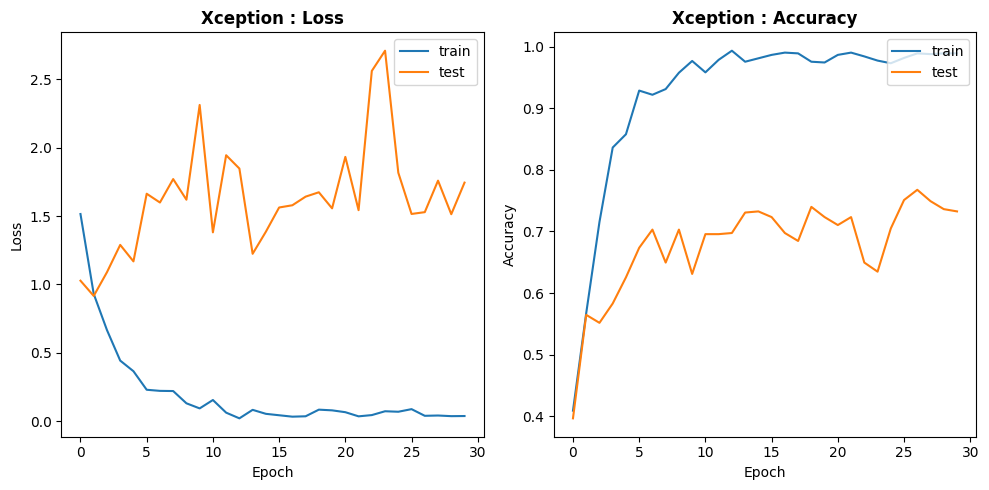

In [ ]:
plot_performance(model_name='Xception',
                acc=xception_history.history['accuracy'],
                 val_acc=xception_history.history['val_accuracy'],
                 loss=xception_history.history['loss'],
                 val_loss=xception_history.history['val_loss'])

#### With Augmentation

In [ ]:
checkpointer_xception_aug = ModelCheckpoint(filepath='xception_aug.weights.best.hdf5', verbose=3, save_best_only=True)

xception_history_aug=xception_model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train)//batch_size,
    epochs=epochs,
    callbacks=[checkpointer_xception_aug]
)

Epoch 1/30
50/50 [==============================] - ETA: 0s - loss: 1.1287 - accuracy: 0.5437
Epoch 1: val_loss improved from inf to 0.85212, saving model to xception_aug.weights.best.hdf5
50/50 [==============================] - 37s 706ms/step - loss: 1.1287 - accuracy: 0.5437 - val_loss: 0.8521 - val_accuracy: 0.5886
Epoch 2/30
50/50 [==============================] - ETA: 0s - loss: 0.8388 - accuracy: 0.6436
Epoch 2: val_loss did not improve from 0.85212
50/50 [==============================] - 25s 494ms/step - loss: 0.8388 - accuracy: 0.6436 - val_loss: 1.8159 - val_accuracy: 0.6292
Epoch 3/30
50/50 [==============================] - ETA: 0s - loss: 0.7051 - accuracy: 0.7134
Epoch 3: val_loss did not improve from 0.85212
50/50 [==============================] - 25s 495ms/step - loss: 0.7051 - accuracy: 0.7134 - val_loss: 0.9030 - val_accuracy: 0.7066
Epoch 4/30
50/50 [==============================] - ETA: 0s - loss: 0.6657 - accuracy: 0.7436
Epoch 4: val_loss improved from 0.85212

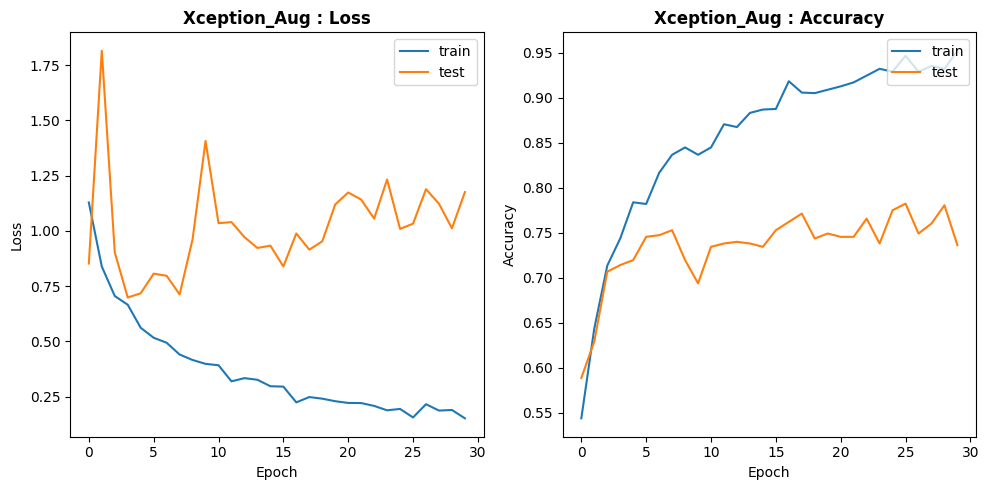

In [ ]:
plot_performance(model_name='Xception_Aug',
                acc=xception_history_aug.history['accuracy'],
                 val_acc=xception_history_aug.history['val_accuracy'],
                 loss=xception_history_aug.history['loss'],
                 val_loss=xception_history_aug.history['val_loss'])

# Model Comparision and Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
models=pd.read_excel('model_comparision.xlsx', sheet_name='Data')
aug_models=pd.read_excel('model_comparision.xlsx', sheet_name='Augmentation')

In [ ]:
models= models.merge(aug_models, on='model', suffixes=['', '_aug'])

In [ ]:
models.loc[3, 'val_loss_aug']=7    #reason provided below
models

,model,loss,val_loss,acc,val_acc,time_ms,loss_aug,val_loss_aug,acc_aug,val_acc_aug,time_ms_aug
0,own_model,0.052900,5.6829,0.9864,0.4889,237,0.9809,0.9935,0.4972,0.4963,18360
1,inception,0.000018,1.7240,1.0000,1.7240,6112,0.4550,0.8586,0.8400,0.7196,20397
2,resnet,0.019900,1.8248,0.9932,1.8248,19376,0.3016,0.9454,0.8699,0.7269,27538
3,xception,0.038300,1.7449,0.9889,0.7325,14270,0.1513,7.0000,0.9522,0.7362,24481


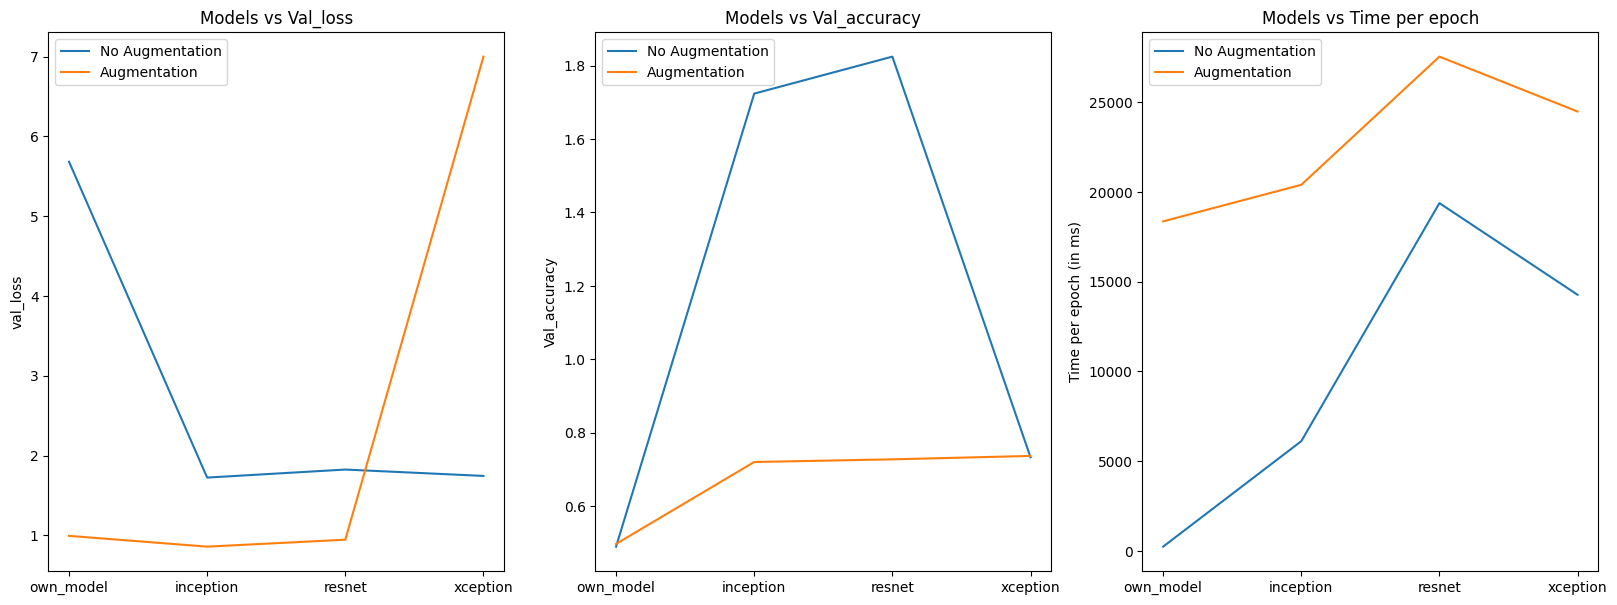

In [ ]:
plt.figure(figsize=(20,7))

plt.subplot(1,3,1)
plt.plot(models.model, models.val_loss)
plt.plot(models.model, models.val_loss_aug)
plt.legend(['No Augmentation', 'Augmentation'])
plt.ylabel('val_loss')
plt.title('Models vs Val_loss');

plt.subplot(1,3,2)
plt.plot(models.model, models.val_acc)
plt.plot(models.model, models.val_acc_aug)
plt.legend(['No Augmentation', 'Augmentation'])
plt.ylabel('Val_accuracy')
plt.title('Models vs Val_accuracy')

plt.subplot(1,3,3)
plt.plot(models.model, models.time_ms)
plt.plot(models.model, models.time_ms_aug)
plt.legend(['No Augmentation', 'Augmentation'])
plt.ylabel('Time per epoch (in ms)')
plt.title('Models vs Time per epoch');

<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Loading Best Model</h1>

In [ ]:
xception_model.load_weights('xception_aug.weights.best.hdf5')

<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Visualising Kernels</h1>

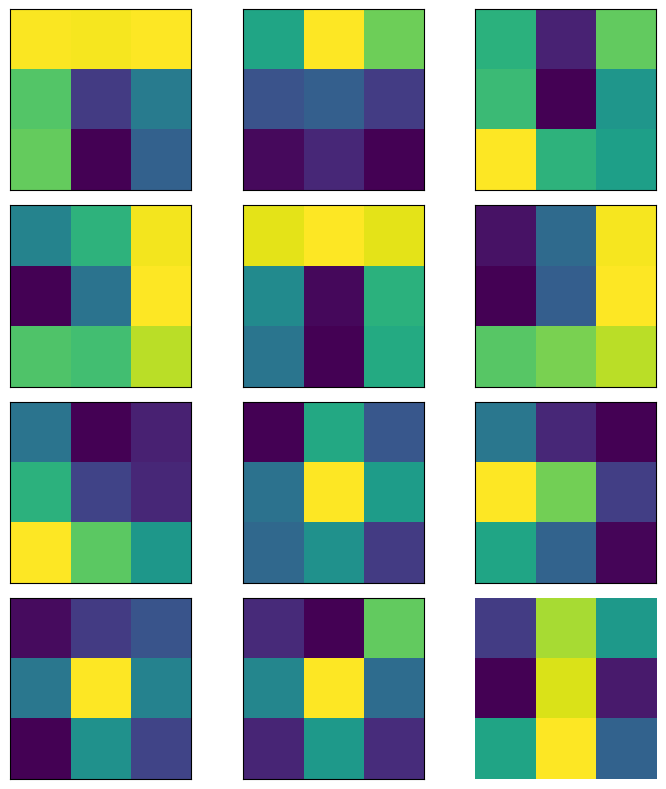

In [ ]:
fig, ax= plt.subplots(4,3, figsize=(8,8))

for i, ax in zip(range(12), ax.flatten()):

  conv1=xception_model.layers[0]
  weights1 = conv1.get_weights()
  kernels1 = weights1[0]
  kernel1_1 = kernels1[:,:,0,i]
  ax.imshow(kernel1_1)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.tight_layout()
  plt.axis('off');

Lets understand what features these kernel extract? What these kernels see?

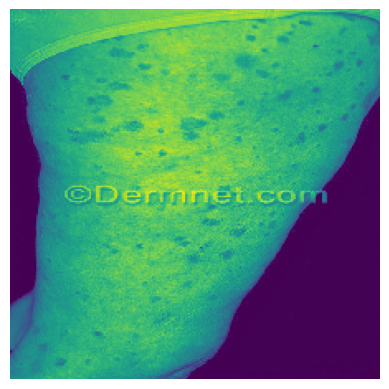

In [ ]:
image = tf.keras.utils.load_img('/content/drive/MyDrive/TA/Data/data.jpg', target_size=input_shape_2D)
input_arr = tf.keras.utils.img_to_array(image)/255
image = input_arr[:, :, 1]
plt.imshow(image)
plt.axis('off');

In [ ]:
import numpy as np

def convolution(image, kernel):
    # Get the size of the kernel
    kernel_size = kernel.shape[0]

    # Calculate the size of the output image
    output_size = image.shape[0] - kernel_size + 1

    # Initialize the output image
    output_image = np.zeros((output_size, output_size))

    # Pad the image with zeros
    padded_image = np.pad(image, ((kernel_size-1)//2, (kernel_size-1)//2), 'constant')

    # Apply the convolution operation
    for ii in range(output_size):
        for jj in range(output_size):
            window = padded_image[ii:ii+kernel_size, jj:jj+kernel_size]
            output_image[ii, jj] = np.sum(window * kernel)

    return output_image


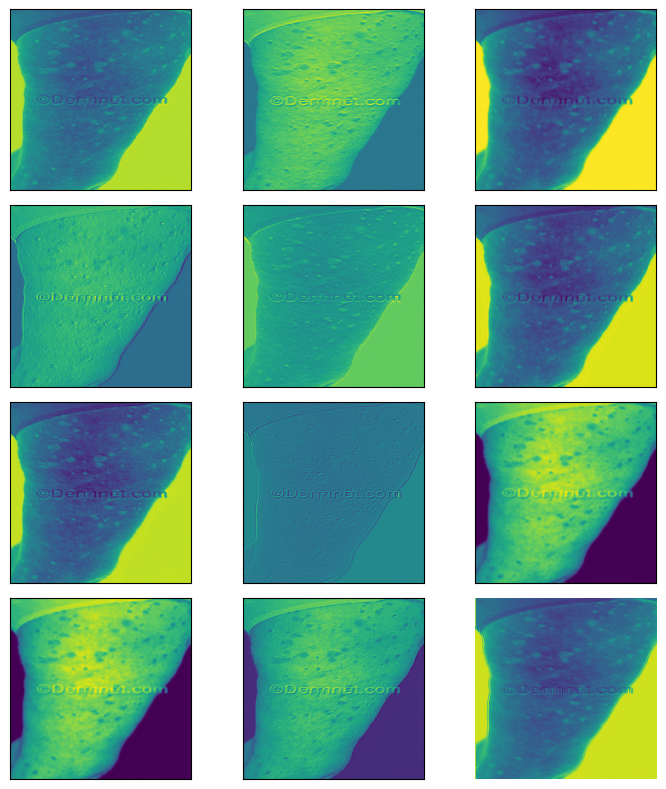

In [ ]:
fig, ax= plt.subplots(4,3, figsize=(8,8))

for i, ax in zip(range(12), ax.flatten()):

  conv1=xception_model.layers[0]
  weights1 = conv1.get_weights()
  kernels1 = weights1[0]
  kernel1_1 = kernels1[:,:,0,i]

  output=convolution(image, kernel1_1)

  ax.imshow(output)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.tight_layout()
  plt.axis('off');


<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Visualising Prediction</h1>


In [ ]:
# get predictions on the test set
y_hat = xception_model.predict(X_test)

# define text labels
labels = data_ds.class_names

17/17 [==============================] - 5s 151ms/step


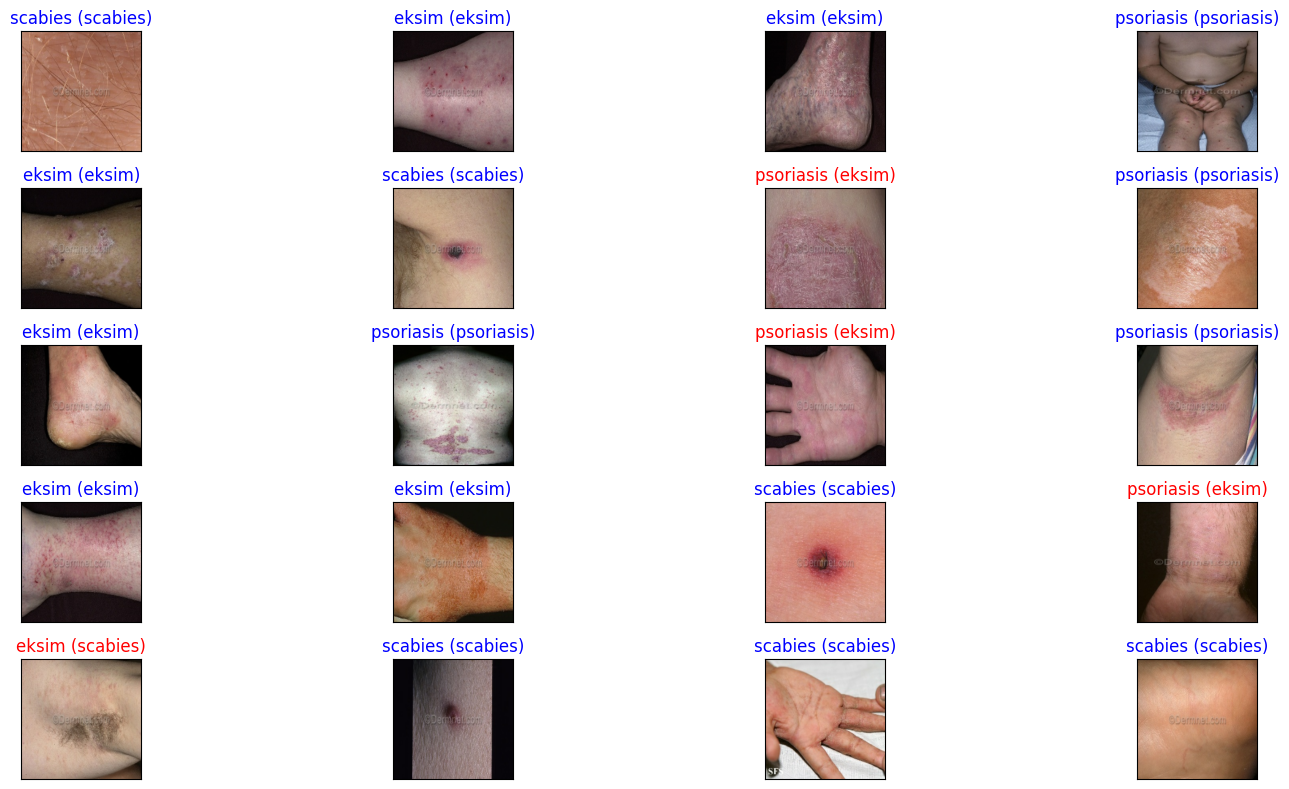

In [ ]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=20, replace=False)):
    ax = fig.add_subplot(5, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "red"))
    plt.tight_layout()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

# Define label/category names
label_names = ['Eksim','Psoriasis','Scabies']  # Replace with your actual label names

# Initialize empty arrays to store predictions and labels
predicted_classes = []
true_classes = []

# Randomly sample from the test data
random_samples = np.random.choice(X_test.shape[0], size=100, replace=False)

for idx in random_samples:
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])

    # Store predictions and labels for each sample
    predicted_classes.append(pred_idx)
    true_classes.append(true_idx)

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Create a Pandas DataFrame from the confusion matrix
labels = [label_names[i] for i in np.unique(true_classes)]
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Calculate TP, FP, TN, FN
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)

# Create a DataFrame for TP, FP, TN, FN
metrics_df = pd.DataFrame({'True Positive': TP, 'False Positive': FP, 'True Negative': TN, 'False Negative': FN}, index=labels)

# Calculate additional evaluation metrics
f1_scores = f1_score(true_classes, predicted_classes, average=None)
accuracy = accuracy_score(true_classes, predicted_classes)
precisions = precision_score(true_classes, predicted_classes, average=None)
recalls = recall_score(true_classes, predicted_classes, average=None)

# Create a Pandas DataFrame for additional evaluation metrics
additional_metrics_df = pd.DataFrame({'F1-score': f1_scores, 'Accuracy': accuracy, 'Precision': precisions, 'Recall': recalls}, index=labels)

print("Metrics:")
print(metrics_df)

print("\nAdditional Metrics:")
print(additional_metrics_df)


Metrics:
           True Positive  False Positive  True Negative  False Negative
Eksim                 18               3             63              16
Psoriasis             36              16             43               5
Scabies               19               8             67               6

Additional Metrics:
           F1-score  Accuracy  Precision    Recall
Eksim      0.654545      0.73   0.857143  0.529412
Psoriasis  0.774194      0.73   0.692308  0.878049
Scabies    0.730769      0.73   0.703704  0.760000
